# Hello again, Uncertainty

Fall 2023
https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng()

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}} \newcommand{\cor}{\text{cor}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\cor` and `\sd` in LaTeX below.

# Prediction and Estimation

Suppose I've collected data on rent in Eugene.
Consider the following questions:

1. How much does rent cost in the Bethel neighborhood this year?
2. How much is rent changing by, per year?

*Question:* What would good answers to these questions look like?

We could answer these questions by

- reporting empirical averages from the actual data
- fitting a black-box predictor and asking it questions
- fitting a model with explicit terms for neighborhood and year

*(Discuss pros and cons and how these would actually work.)*

# A third question

3. How sure are you about those answers?

> 1. How much does rent cost in the Bethel neighborhood this year?


Note that this has two notions of uncertainty:
rents come in a range of values, but also there will be uncertainty in our estimates of that range.

# Uncertainty, by math

## Reminder: confidence intervals

If we have $n$ independent samples from some source,
and the sample mean and SD are $\bar x$ and $s$ respectively,
then a 95% confidence interval is
$$ \bar x - t_n s \qquad \text{to} \qquad \bar x + t_n s , $$
where $t_n$ is the 97.5% quantile for the $t$ distribution with $n-2$ degrees of freedom.

*Said another way:* $\bar x$ is our estimate of the mean,
and math gives us an estimate of the uncertainty behind our estimate.

1. How much does rent cost in the Bethel neighborhood this year?

**(Take the mean of the rents in Bethel this year.)**

2. How much is rent changing by, per year?

**(Take the mean difference in rent of places that go up for rent in adjacent years.)**

3. How sure are you about those answers?

**(Get 95% CIs for them.)**

# A model

For example: suppose we fit a model where
the price of the $i^\text{th}$ apartment is
$$\begin{aligned}
    p_i &= \beta_{n_i} + \beta_\text{year} y_i + \beta_\text{area} a_i + \epsilon_i \\
    \epsilon_i &\sim \text{Normal}(0, \sigma) ,
\end{aligned}$$
where
- $p_i$ is the price (in dollars)
- $n_i$ is the neighborhood,
- $\beta_n$ is the mean price in neighborhood $n$
- $y_i$ is the year
- $\beta_\text{year}$ is the amount that rent changes by, per year, on average
- $a_i$ is the area in square feet
- $\beta_\text{area}$ is the amount that rent goes up per additional square foot, on average
- $\epsilon_i$ is the residual, and
- $\sigma$ is how much otherwise similar apartments differ in price

1. How much does rent cost in the Bethel neighborhood this year?

**(Our estimate of $\beta_\text{Bethel}$.)**

2. How much is rent changing by, per year?

**(Our estimate of $\beta_\text{year}$.)**

3. How sure are you about those answers?

**???**

## Aside: how do we fit this model?

We'll do it in two lines,
with [patsy](https://patsy.readthedocs.io/en/latest/quickstart.html)
and `np.linalg.lstsq`.

First, let's read in [the data](data/housing.csv).
*(Note: it's fake data.)* ([github link](https://github.com/UOdsci/dsci345/raw/main/class_material/slides/data/housing.csv))

In [2]:
df = pd.read_csv("data/housing.csv", index_col=0)
df

,hood,year,area,rent
0,river,2014,489.0,942.0
1,bethel,2010,610.0,370.0
2,churchill,2017,385.0,669.0
3,bethel,2012,757.0,624.0
4,bethel,2019,504.0,990.0
...,...,...,...,...
395,bethel,2012,238.0,579.0
396,campus,2016,287.0,759.0
397,churchill,2016,526.0,679.0
398,campus,2014,418.0,868.0


Next, let's shift the variables, so that for instance
$\beta_\text{Bethel}$ is the average price of a 500 ft${}^2$ apartment in 2010
(instead of a 0 ft${}^2$ apartment in the year 0):

In [3]:
df['area'] -= 500
df['year'] -= 2010

Now, fit the model,
using patsy to make the *design matrix* (see board):

In [27]:
import patsy
outcome, predictors = patsy.dmatrices("rent ~ 0 + hood + year + area", df)
fit = np.linalg.lstsq(predictors, outcome, rcond=None)

estimates = { k.lstrip('hood[').rstrip("]") : v for k, v in zip(predictors.design_info.column_names, fit[0].ravel())}

estimates

{'bethel': 556.0088681522523,
 'campus': 649.8851743401476,
 'churchill': 584.0968576228607,
 'river': 610.4626011683356,
 'whittaker': 643.2011227181572,
 'year': 31.218431226183213,
 'area': 0.10063620684218222}

In [21]:
np.asarray(predictors)[:10,:]

array([[   0.,    0.,    0.,    1.,    0.,    4.,  -11.],
       [   1.,    0.,    0.,    0.,    0.,    0.,  110.],
       [   0.,    0.,    1.,    0.,    0.,    7., -115.],
       [   1.,    0.,    0.,    0.,    0.,    2.,  257.],
       [   1.,    0.,    0.,    0.,    0.,    9.,    4.],
       [   0.,    0.,    0.,    0.,    1.,    5.,  -16.],
       [   0.,    0.,    0.,    1.,    0.,    6.,   93.],
       [   1.,    0.,    0.,    0.,    0.,    4., -196.],
       [   1.,    0.,    0.,    0.,    0.,    3.,  163.],
       [   0.,    1.,    0.,    0.,    0.,    2.,   81.]])

In [22]:
df

,hood,year,area,rent
0,river,4,-11.0,942.0
1,bethel,0,110.0,370.0
2,churchill,7,-115.0,669.0
3,bethel,2,257.0,624.0
4,bethel,9,4.0,990.0
...,...,...,...,...
395,bethel,2,-262.0,579.0
396,campus,6,-213.0,759.0
397,churchill,6,26.0,679.0
398,campus,4,-82.0,868.0


# Uncertainty, by simulation

Okay, so we'd like to know
how far off our guesses of $\beta_\text{Bethel}$ or $a$ are
from "the truth".

Well, one way to do this is to *simulate* data where we know the truth,
and then see how far off our guesses are.
If the simulations describe the real data well, 
then this should give us a good estimate.

This is sometimes known as *the parametric bootstrap*.
(We'll meet it's more famous cousin, "the" bootstrap, next.)
We actually did it, last class.
Let's do it again!

Okay, from our "real data" we estimated a certain set of estimated parameter values.
To make the simulated datasets look as much like the real data as possible,
we should simulate using those parameter values.

In [5]:
def sim_rents(n, beta):
    # TODO: change this to use existing 'hood', 'year', and 'area' columns
    hoods = ["bethel", "churchill", "whittaker", "river", "campus"]
    df = pd.DataFrame({
        "hood" : rng.choice(hoods, replace=True, size=n),
        "year" : rng.choice(np.arange(10), replace=True, size=n), # years after 2010
        "area" : np.round(rng.normal(scale=150, size=n)), # relative to 500 ft2
    })
    df['rent'] = np.round(
        np.array([beta[h] for h in df.hood]) + beta['year'] * df.year + beta['area'] * df.area
        + rng.normal(scale=150, size=n)
    )
    return df

In [6]:
def fit_model(df):
    outcome, predictors = patsy.dmatrices("rent ~ 0 + hood + year + area", df)
    fit = np.linalg.lstsq(predictors, outcome, rcond=None)
    estimates = { k.lstrip('hood[').rstrip("]") : v for k, v in zip(predictors.design_info.column_names, fit[0].ravel())}
    return estimates

In [28]:
experiments = pd.DataFrame([
    fit_model(sim_rents(n=500, beta=estimates))
    for _ in range(1000)
])
experiments

,bethel,campus,churchill,river,whittaker,year,area
0,553.129388,636.782335,566.790531,629.834955,631.315944,33.044571,0.148637
1,546.389645,653.301417,535.018897,611.376905,650.518137,33.038017,0.088296
2,558.117169,676.164650,603.882570,609.233100,631.745660,31.031249,0.027875
3,578.508743,650.071314,596.373620,629.513868,651.443396,28.992217,0.026167
4,561.942113,665.732217,606.196788,593.298654,665.981267,28.483740,0.093528
...,...,...,...,...,...,...,...
995,538.166340,604.119317,530.887685,599.281834,643.743802,34.672483,0.062561
996,561.093625,666.110372,585.613416,599.759788,649.020167,30.866896,0.064493
997,542.858757,617.818254,585.387913,608.054368,643.774205,33.102289,0.169135
998,548.272569,646.682739,591.073084,638.657332,647.991229,29.784093,0.044494


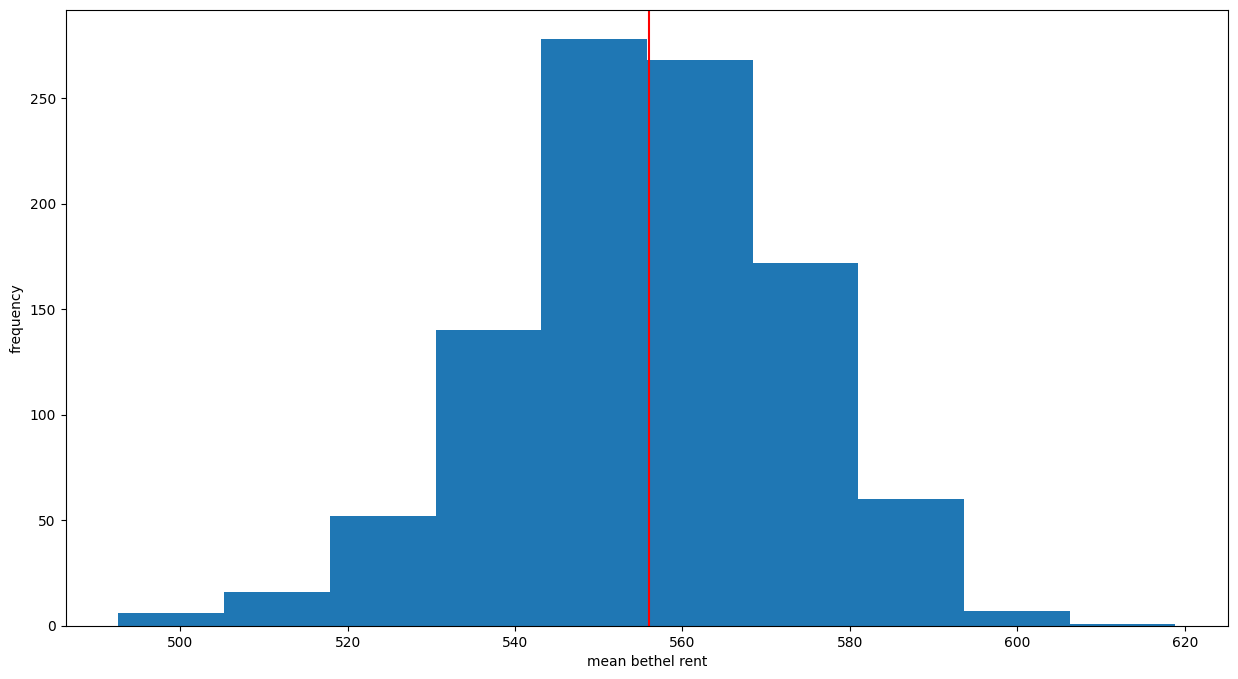

In [30]:
plt.hist(experiments.bethel)
plt.xlabel("mean bethel rent"); plt.ylabel("frequency");
plt.axvline(estimates['bethel'], color='red')

**Conclusion:** The mean rent in Bethel for 500 ft${}^2$ apartments in 2010
as about \\$556, with a 95% confidence interval of about \\$517 to \\$594.

Widths of other 95% confidence intervals are below.

In [13]:
experiments.quantile(0.975) - experiments.quantile(0.025)

bethel       77.119173
campus       69.725638
churchill    69.460268
river        70.343363
whittaker    71.668009
year          9.279153
area          0.181946
dtype: float64

# Uncertainty, by our bootstraps

*However*, sometimes we don't have
(or can't be bothered to make)
a good generative model
to simulate from.
Or we tried and it was hard to get realistic-looking data.
What to do then?

Well, what we'd *like* to do is to draw a bunch of new datasets
from wherever we got the first one.

This seems unrealistic... *but*, our best guess at what that would be like if we could...
is our dataset itself!

## The bootstrap

Suppose we have a method that estimates something.
To get an estimate of *uncertainty* of that estimate,

1. Obtain a new dataset, of the same size as the original,
    by resampling *with replacement* observations from the original dataset.
    
2. Apply the method to this 'bootstrapped' dataset.

3. Repeat lots of times.

Then, the middle 95% of the estimates
gives you the "bootstrap 95% confidence interval".

## Exercise:

Here are 10 numbers.
```
array([176, 255,  53,  94,  61, 119,  42, 109,   0,  30])
```

1. Compute the median.
2. 1,000 times, resample 10 numbers, with replacement, from this list of numbers,
    and compute the median.
3. Make a histogram of those 1,000 medians, with the original median as a vertical line.

In [45]:
x = np.array([176, 255,  53,  94,  61, 119,  42, 109,   0,  30])
obs_median = np.median(x)

def boot_med(x, num_boots):
    out = np.zeros(num_boots)
    for k in range(num_boots):
        bx = rng.choice(x, size=len(x))
        out[k] = np.median(bx)
    return out

boot_med(x, 10)

array([ 42. ,  57. ,  73.5,  94. , 101.5,  94. ,  77.5,  41.5,  57. ,
        53. ])

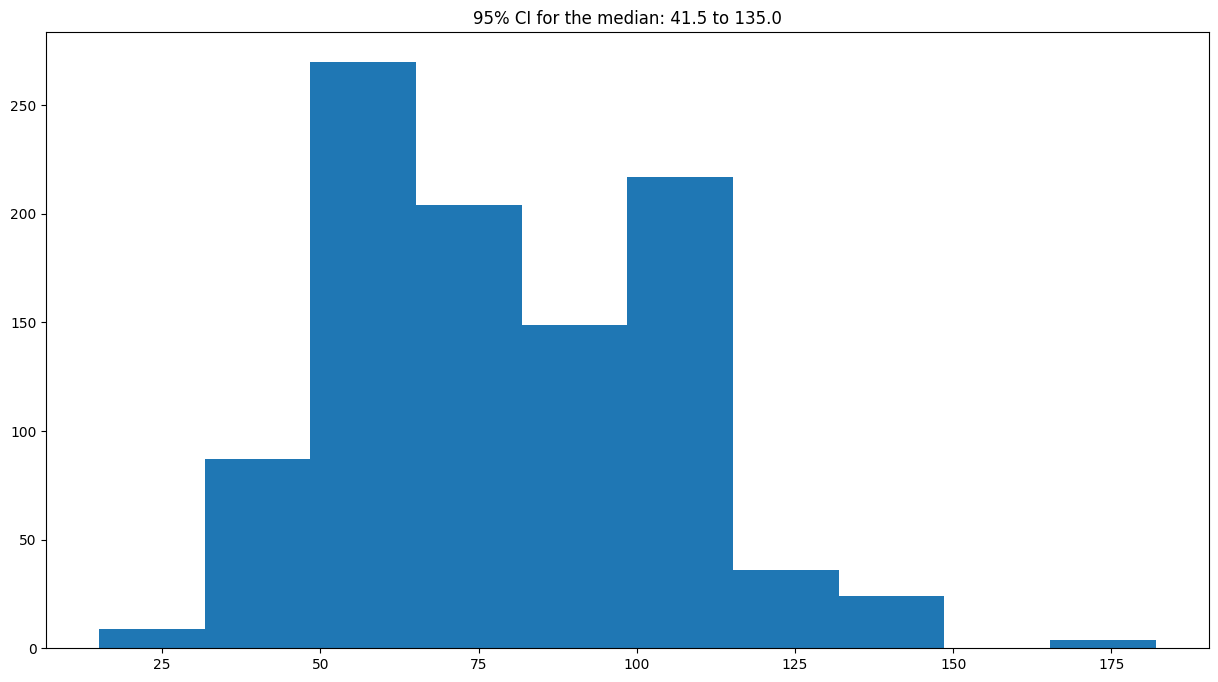

In [48]:
boot_reps = boot_med(x, 1000)
plt.hist(boot_reps)
plt.title(
    f"95% CI for the median: {np.quantile(boot_reps, 0.025)} to {np.quantile(boot_reps, 0.975)}"
);

Here's a (very) simple method to obtain a bootstrap resampled version of a data frame:

In [9]:
def bootstrap(df):
    n = df.shape[0]
    return df.loc[rng.choice(n, n)]

And, here, let's apply the`fit_model` method above to 1000 of these.

In [10]:
boots = pd.DataFrame([
    fit_model(bootstrap(df))
    for _ in range(1000)
])
boots

,bethel,campus,churchill,river,whittaker,year,area
0,566.178533,673.454074,572.670839,650.981769,631.659294,29.871761,0.052712
1,569.876770,661.566126,573.540746,602.964247,618.121608,32.437806,0.153979
2,560.932447,646.536876,584.596285,646.603953,660.974635,29.749610,0.081730
3,547.287149,643.902694,579.080515,608.663384,603.393940,31.501915,0.045602
4,539.682865,646.525045,609.888808,627.118967,657.588515,30.051460,0.180413
...,...,...,...,...,...,...,...
995,539.602579,659.099466,572.510073,600.792865,610.673226,31.952523,0.120829
996,548.591574,601.780609,571.831343,631.447685,648.958472,31.437289,0.178433
997,547.403821,644.033426,582.261111,635.851331,669.104292,31.075540,-0.007286
998,583.384967,653.739912,577.262960,619.867603,650.517642,30.868396,0.096619


And, here is the distribution of estimates of $\beta_\text{Bethel}$.
It is similar, but not identical, to our other distribution above (as expected).

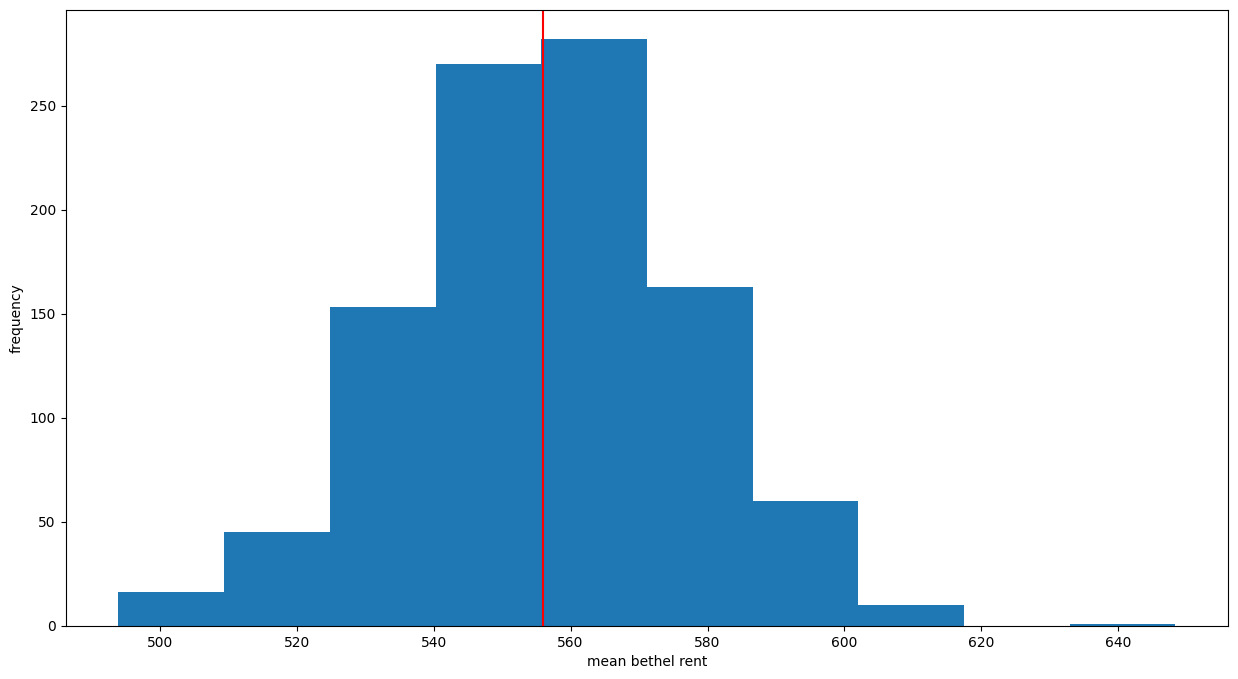

In [49]:
plt.hist(boots.bethel)
plt.xlabel("mean bethel rent"); plt.ylabel("frequency");
plt.axvline(estimates['bethel'], color='red');

**Conclusion:** The mean rent in Bethel for 500 ft${}^2$ apartments in 2010
as about \\$556, with a 95% confidence interval of about \\$516 to \\$595.

Widths of other 95% confidence intervals are below.

In [17]:
boots.quantile(0.975) - experiments.quantile(0.025)

bethel       79.772687
campus       80.884375
churchill    76.273014
river        75.963004
whittaker    72.911259
year          9.611364
area          0.196990
dtype: float64